# Intro

Here we'll put together a simple toy accelerator and use it to generate data so we can play around with a few machine learning algorithms. The focus here is to create a model that learns to mimic some aspects of the toy accelerator simulation. <br />



# Toy Accelerator Model

Simple longitudinal phase space example, mapping particles through a linac and then an arc. 

Produces longitudinal phase space screens for various linac phases. 


In [ ]:
import numpy as np

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline 

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from math import cos, pi, sqrt

c_light = 299792458.


Make a bunch in $(z, \delta)$ space at reference energy $E_0$, where $z=-ct$ and the relative energy spread $\delta = (E-E_0)/E_0$.

In [65]:
# Simple bunch in longitudinal phase space

# z = - c t
sigma_z = 0.001; # units: meters
# delta = (E-E0)/ E0 relative energy spread
sigma_delta= .0001; # units: 1

nparticles = 1000;

# Gussian Distribution initial bunch
dist_mean = [0,0]
dist_covariance =  [[sigma_z**2, 0], [0, sigma_delta**2]]

def init_bunch(n_particles):
  return np.random.multivariate_normal(dist_mean,dist_covariance, n_particles);
bunch0 = init_bunch(nparticles)



# Bunch data
bunch0

array([[-1.08263883e-03,  6.14619855e-05],
       [ 4.80683253e-04,  1.20543447e-04],
       [ 9.65966360e-05, -2.92206581e-05],
       ...,
       [-9.69171264e-04, -1.59914888e-05],
       [-4.96575353e-05,  7.50573015e-05],
       [ 1.79882914e-04, -1.31298567e-05]])

In [66]:
# Some statistics
def bunch_stats(bunch):
  stats = {}
  stats['z_min'], stats['delta_min'] = np.amin(bunch, 0)
  stats['z_max'], stats['delta_max'] = np.amax(bunch, 0)
  stats['sigma_z'], stats['sigma_delta'] = list(map(sqrt, np.var(bunch, 0)))
  
  return stats

bunch_stats(bunch0)

{'delta_max': 0.000276580147609675,
 'delta_min': -0.00037403226411399543,
 'sigma_delta': 9.922663304949029e-05,
 'sigma_z': 0.0009805404210482432,
 'z_max': 0.0035480690009166683,
 'z_min': -0.002878962531253099}

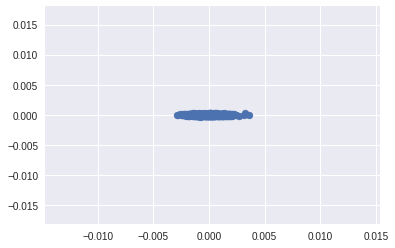

In [67]:
# Simple plot. 
plt.scatter(*bunch0.T)
plt.show()

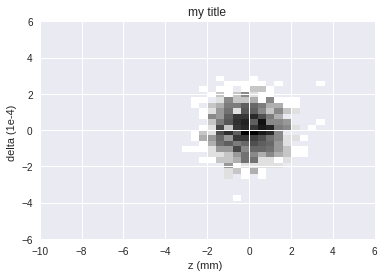

In [68]:
# Better plot

def plot_bunch(bunch, title=None, range=[(-6,6), (-6,6)]):
  x,y =bunch.T
  # colab limitations:
  #   This looks nicer on a local machine
  #   tex doesn't work: plt.rc('text', usetex=True)
  #   plt.xlabel(r'\textbf{time} (s)')
  
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.set_xlabel('z (mm) ')
  ax.set_ylabel('delta (1e-4) ')
  if title: ax.set_title(title)
    
  ax.hist2d(1e3*x, 1e4*y, bins=40, norm=LogNorm(), range=range );
  #plt.colorbar()  
 
  return fig

  
plot_bunch(bunch0, title='my title', range=[(-10,6), (-6,6)]);

Simple Cavity map. Acceleration from energy $E_0$ to $E_1$ through a cavity with phase $\phi$, frequency $f$, and $k=2\pi f/c$.

$z \rightarrow z \\ 
\delta \rightarrow \delta \frac{E_0}{E_1} + (1- \frac{E_0}{E_1})\frac{\cos(kz +\phi)}{\cos(\phi)}$

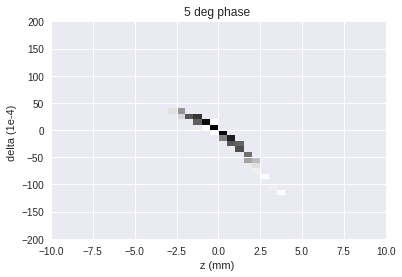

In [69]:
# Accelerate through a linac

def linac(bunch, energy0=100e6, energy1=1000e6, frf=1.3e9, phi=2*pi*(0/360)):
  """
  Simple linac (cavity) map. Accelerates from energy0 to energy1, with rf frequency frf (Hz) and phase phi (rad). 
  """
  k = 2*pi*frf/c_light
  return np.array([ (z, (1-energy0/energy1)*(cos(k*z+phi)/cos(phi) -1)+ energy0/energy1 *delta) for (z,delta) in bunch])
  

bunch1 = linac(bunch0, phi=2*pi*(5/360))
plot_bunch(bunch1, title = '5 deg phase ', range=[(-10,10), (-200,200)]);

Simple longitudinal arc map, parameterized by $r_{56}$ and $t_{566}$:

$z \rightarrow z + r_{56}\,\delta + t_{566}\,\delta^2 \\ 
\delta \rightarrow \delta$

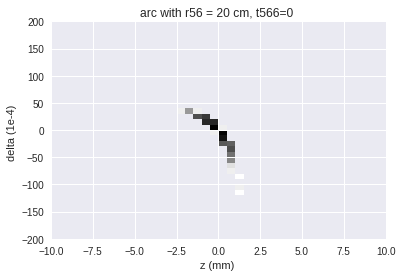

In [70]:
# Transport through an arc

def arc(bunch, r56=0, t566=0):
  """
  Simple arc with transport terms r56 and t566
  z -> z + r56*delta + t566*delta**2
  delta -> delta
  """
  return np.array([(z + r56*delta + t566*delta**2, delta) for (z, delta) in bunch])
 
bunch2 = arc(bunch1, r56 = 20e-2, t566 = 0)

plot_bunch(bunch2, title = 'arc with r56 = 20 cm, t566=0 ', range=[(-10,10), (-200,200)]);

{'delta_max': 0.0096562697468347,
 'delta_min': -0.019515940270560046,
 'sigma_delta': 0.004243044754782761,
 'sigma_z': 0.000156023885926989,
 'z_max': 0.00010879517036717565,
 'z_min': -0.0008544650364625238}

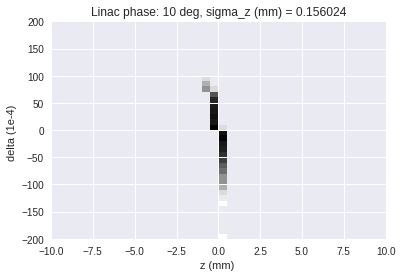

In [71]:
# Accelerator: Linac, then arc.
# Return statistics

def my_accelerator(phase_deg, energy_final = 1000e6, r56_in = 20e-2, t566_in = 1, plot_result = False):
  bunch1 = linac(bunch0, energy1 = energy_final, phi = 2*pi*(phase_deg/360))
  bunch2 = arc(bunch1, r56 = r56_in, t566 = t566_in)
  
  stats = bunch_stats(bunch2)
  sigz = '{:f}'.format(1000*stats['sigma_z'])
  
  title = 'Linac phase: '+str(phase_deg)+' deg, sigma_z (mm) = '+sigz
  if plot_result == True:
    plot_bunch(bunch2, title=title, range=[(-10,10), (-200,200)])
  
  return stats
  

mystats = my_accelerator(10, plot_result = True);
mystats

# **Regression **

Now, let's try to learn a machine model using data generated by our accelerator! 







## **1. A Few Practical Considerations and Rules of Thumb for NNs**

**1. Learning rate: **
  * Too large: will bounce around / out of minima and not converge
  * Too small: will take a very long time to converge and has less chance to find better local minima (vs. just converging to first one found)

**2. Number of layers / nodes:** 
  * Set free parameters relative to problem complexity:
    * Too many:
      * easy to overfit the data and typically makes the network generalize less well
      * training takes longer (esp. problematic for deep networks where gradient seen by earlier layers becomes very small)
    * Too few: 
      * underfitting the data
  * There are many heuristics for choosing initial number of nodes / layers (and this varies depending on architecture + amount of data available)
    * Input and output layer are just the number of inputs/outputs
    * For simple feedforward networks: some smooth transition between the number of input/output variables is often the starting point (with number of layers chosen on expected complexity of the data); e.g. 1st hidden 2/3 the input layer size + number outputs
      * e.g. linearly separable ... don't need any hidden layers
      * one hidden layer with tanh activation function --> can in theory approximate any continuous map ("universal appx theorem")
  * Automated architecture search is a less-used option (typically, starting with a small network and iterating by hand or with a small grid search can be very efficient)
 
**3. Combatting overfitting:**
  * Smaller network
  * More data
  * Regularization methods (e.g. dropout, l2 or l1 penalty on weights)
  


## **2. Generate a Data Set**

Let's generates our input/output examples.

> **X:** Accelerator input features [phase, energy, r56, t566].<br />
> **Y:** Accelerator outputs [sigma_z, sigma_delta].


Define the range of the input variables, how many samples we want, and the number of features and targets

In [ ]:
num_samples = 1000 # this will be the number of training samples to use
phase_range = 100 # this will become -50 to 50 deg
energy_range = 800e6 # this will become 500e6 to 1300e6
energy_min = 500e6 # this is the minimum energy to accelerate to
r56_range = 1 # this will become -0.5 to 0.5
num_features = 4
num_targets = 2

First, we want to send a variety of combinations of input variables to the accelerator. So, let's use the numpy random.rand() function to generate random values between 0 and 1 in an array that's the size of our input data (number of samples, number of input variables)

In [ ]:
X = np.random.rand(num_samples, num_features) # makes an array the same size as X with random values between 0 and 1

Now our input array (X) is populated with random values between 0 and 1, but we want some realistic numbers for our accelerator. So, we'll multiply each column by the full-scale range we want the values to span and provide appropriate offsets. Then, we'll  replace the corresponding column with these new values. 

In [ ]:
X[:,0]=X[:,0]*(phase_range) - phase_range/2.0  
X[:,1]=X[:,1]*(energy_range) + energy_min  
X[:,2]=X[:,2]*(r56_range) - r56_range/0.5
X[:,3]=(X[:,3] - 0.5)*0.00001 # we'll keep this small for now

Next we pre-allocate space in a separate numpy array (Y) for the output variables, using the numpy zeros((dim)) function. This generates a numpy array of the specified dimension filled only with zeros. We'll fill the array with real values in a moment.

In [ ]:
Y = np.zeros((num_samples, num_targets))

Here we'll send each sample of input data to the toy accelerator function and fill the output array one sample at a time.

In [ ]:
for i in range(0,num_samples):
  stats=my_accelerator(X[i,0],X[i,1],X[i,2],X[i,3])
  Y[i,0] = stats['sigma_z'] 
  Y[i,1] = stats['sigma_delta']


Let's sort these by phase so we can take a look at the data.

Text(0.5,0,'phase [deg]')

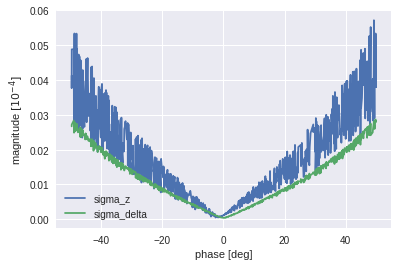

In [77]:
idx=X[:,0].argsort(kind='mergesort')
plt.plot(X[idx][:,0],Y[idx][:,0])
plt.plot(X[idx][:,0],Y[idx][:,1])
plt.legend(['sigma_z','sigma_delta'])
plt.ylabel('magnitude ' +  '$[10^{-4}]$')
plt.xlabel('phase [deg]')


## ** 3. Now Let's Train Some Models**




#### *helper functions for plotting/printing - you can ignore these*

In [ ]:
# some helper functions for printing/plotting

def print_trn_val_errors(val_pred,train_pred, Y_val,Y_train):
  
  val_error=np.absolute(np.mean(val_pred-Y_val,axis=0))
  train_error=np.absolute(np.mean(train_pred-Y_train,axis=0))
  
  val_error_max=np.max(np.absolute(val_pred-Y_val),axis=0)
  train_error_max=np.max(np.absolute(train_pred-Y_train),axis=0)
  
  train_std=np.std(np.absolute(train_pred-Y_train),axis=0)
  val_std=np.std(np.absolute(val_pred-Y_val),axis=0)
  print(' ')
  print('                    ', '\033[1m'+ 'sigma_z MAE','    ','sigma_delta MAE','    ','sigma_z peak AE','       ','sigma_delta peak AE','    ','sigma_z STD AE','         ','sigma_delta STD AE')
  print('\033[1m'+'training error:    '+'\033[0m', '% 10.8f' % train_error[0], '    ', '% 10.8f'% train_error[1],'        ', '% 10.8f'% train_error_max[0],'           ', '% 10.8f'% train_error_max[1], '            ', '% 10.8f'%  train_std[0], '            ', '% 10.8f'%  train_std[1])
  print('\033[1m'+'validation error:  '+'\033[0m', '% 10.8f'% val_error[0],'    ','% 10.8f'% val_error[1],'        ', '% 10.8f'% val_error_max[0],'           ', '% 10.8f'% val_error_max[1], '            ', '% 10.8f'%  val_std[0], '            ', '% 10.8f'%  val_std[1])
  print(' ') 
  
  return

def print_error(pred, Y):
  
  error=np.absolute(np.mean(pred-Y,axis=0))
  
  error_max=np.max(np.absolute(pred-Y),axis=0)
  
  std=np.std(np.absolute(pred-Y),axis=0)
  
  print(' ')
  print('                    ', '\033[1m'+'sigma_z MAE','    ','sigma_delta MAE','    ','sigma_z peak AE','       ','sigma_delta peak AE','    ','sigma_z STD AE','         ','sigma_delta STD AE')
  print('\033[1m'+'error:             '+'\033[0m', '% 10.8f' %  error[0], '    ', '% 10.8f'%  error[1], '        ', '% 10.8f'%  error_max[0],'           ', '% 10.8f'%  error_max[1],  '            ', '% 10.8f'%  std[0], '            ', '% 10.8f'%  std[1] )
  print(' ')
  
  return

def error_plot(pred_e,Y_e,plot_text_e=' (val set shown)',show=False):
  
  error=np.absolute(pred_e-Y_e)
  
  plt.fill_between(np.arange(0,error.shape[0]), np.zeros(error.shape[0]),error)
  plt.title('Sigma_z Prediction Error \n' + str(plot_text_e))
  plt.xlabel('Sample Number')
  plt.ylabel('Sigma_z Absolute Error [norm]')
  plt.ylim(0,1.5)
  
  if show == True:
    plt.show()
    
  return

def error_plot2(X,pred_e,Y_e,plot_text_e=' (val set shown)',show=False):
  

  pred_e=pred_e[X.argsort(kind='mergesort')]
  Y_e=Y_e[X.argsort(kind='mergesort')]
  X=X[X.argsort(kind='mergesort')]


  error=np.absolute(pred_e-Y_e)
  
  plt.fill_between(X, np.zeros(error.shape[0]),error)
  plt.title('Sigma_z Prediction Error \n' + str(plot_text_e))
  plt.xlabel('Phase [norm]')
  plt.ylabel('Sigma_z Absolute Error [norm]')
  plt.ylim(0,1.5)
  
  if show == True:
    plt.show()
    
  return

def Sigma_z_plots(pred,Y,X,plot_text=' (val set shown)'):
  
  # plot simulated, predicted sigma_z
  plt.subplot(1,4,1)
  plt.plot(pred,'r',Y,'b')
  plt.title('Predicted and Simulated Sigma_z \n' + str(plot_text))
  plt.xlabel('Sample Number')
  plt.ylabel('Sigma_z [norm]')
  plt.legend(['Predicted','Actual'])

  # sigma_z error plot
  plt.subplot(1,4,2)
  error_plot(pred,Y,plot_text)
  
  # scatterplot of data and predictions for sigma_z vs phase
  plt.subplot(1,4,3)
  plt.plot(X,pred,'r.')
  plt.plot(X,Y,'b.')
  plt.title('Predicted and Simulated Sigma_z vs. Phase \n' + str(plot_text))
  plt.ylabel('Sigma_z [norm]')
  plt.xlabel('Phase [norm]')
  plt.legend(['Predicted','Actual'])
  
  # sigma_z error plot
  plt.subplot(1,4,4)
  error_plot2(X,pred,Y,plot_text)

  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.001, right=3, hspace=0.25,
                    wspace=0.35)
  plt.show()
  
  return


def Sigma_z_plots_gp(pred,Y,X,sigma,plot_text):
  
  # plot simulated, predicted sigma_z
  plt.subplot(1,3,1)
  plt.plot(pred[:,0], 'r-', label=u'Predicted')
  plt.plot(Y[:,0], 'b-', markersize=10, label=u'Actual')
  plt.title('Predicted and Simulated Sigma_z \n' + str(plot_text))
  plt.xlabel('Sample Number')
  plt.ylabel('Sigma_z [norm]')
  plt.legend()
  
  # sigma_z error plot
  plt.subplot(1,3,2)
  error_plot(pred[:,0],Y[:,0])

  # scatterplot of data and predictions for sigma_z vs phase
  plt.subplot(1,3,3)
  plt.plot(X[:,0],pred[:,0], 'r.', label=u'Predicted')
  plt.plot(X[:,0],Y[:,0], 'b.', label=u'Actual')
  plt.errorbar(X[:,0],pred[:,0], yerr=sigma,fmt='r.',alpha=0.3)
  plt.title('Predicted and Simulated Sigma_z vs. Phase \n' + str(plot_text)) #' 600 points used for train, (val set shown)')
  plt.ylabel('Sigma_z [norm]')
  plt.xlabel('Phase [norm]')
  plt.legend()
  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.001, right=3, hspace=0.25,
                    wspace=0.35)
  plt.show()
  return


### I.  Neural Networks in Sci-kit Learn

Scikit-learn, as we've seen earlier, provides a lot of different tools for machine learning in general. One of them is the MLP Regressor class, which allows you to build feed-forward NNs.

In [ ]:
# load relevant libraries
import sklearn.neural_network as nn 

#### a. Sci-kit learn MLP class



> Let's use the sci-kit learn nn.MLPRegressor class. MLP stands for 'Multi-Layer Perceptron,' which is just a feedforward, fully-connected NN that has three or more layers. The base class has a lot of default inputs:

```
    class sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100, ), 
        activation=’relu’, solver=’adam’, alpha=0.0001, batch_size=’auto’,
        learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, 
        max_iter=200, shuffle=True, random_state=None, tol=0.0001, 
        verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
        early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
        epsilon=1e-08)
```

> But a lot of these aren't meant to be used together and/or can be ignored by most beginners. <br />

<br />

> **Let's go over what some these inputs are:**


> *Neural network definition:*

```
     "activation"          - the activation function used for each node
     "hidden_layer_sizes"  - tuple of number of nodes in each layer
```

> *General training parameters:*

```
     "alpha"               - L2 penalty on the weights
     "batch_size"          - size of the data subset to use for each iteration of weight updates
     "max_iter"            - maximum number of iterations to train for
     "solver"              - optimization algorithm to use to adjust the weights
     "random_state"        - random seed for initialization (if this is set to an integer, you will
                             have the same weight initialization each time)
```

> *Some True/False options related to training and output:*

```
     "shuffle"             - whether to shuffle samples during every training iteration"
     "warm_start"          - whether weights are remembered from previous training
     "early_stopping"      - whether scikit learn will stop the training when the
                              error on a set of held-out data (specified in "validation_fraction") begins
                              to increase or stops decreasing at a specified rate. (This is different than
                              the validation set we're using to compare models).
     "validation_fraction" - how much of the training set is used for
                              early stopping (only active when early_stopping is True)
     "verbose"             - whether to output results from each training iteration
```

> *Solver-specific inputs*:

```
     "beta_1" and "beta_2" - decay rates used in the ADAM opt. algo
     "momentum"            - add a momentum term when using SGD opt.
     "nesterovs_momentum"  - use the Nesterov form of momentum when using SGD opt.
     "learning_rate"       - learning rate to use in SGD opt.
     "learning_rate_init"  - initial learning rate used in ADAM and SGD opt.
```

>More details can be found [here at sci-kit learn's web-page](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor).


#### b. Preprocessing and Separation into Training, Validation, and Testing Sets with Sci-kit Learn



The *MinMaxScaler* class from sci-kit learn makes it really simple to apply the same transform to new data sets without explicitly carrying around information about the original data set. 

>> The calculation the *MinMaxScaler* class does is: 
```
  X_scaled = [(X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))] * (max - min) + min 
```

>>>*where (min,max) is the "feature_range" input to the class*

This is the same calculation that we used before manually.

In [ ]:
# scale the data from -1 to 1
from sklearn import preprocessing

scale_x=preprocessing.MinMaxScaler(feature_range=(-1, 1))
X_scaled=scale_x.fit_transform(X)

scale_y=preprocessing.MinMaxScaler(feature_range=(-1, 1))
Y_scaled=scale_y.fit_transform(Y)


Example of scaling according to previous transform (say here we had some other data, X_new and Y_new):
```
X_new_scaled=scale_x.transform(X_new)
Y_new_scaled=scale_y.transform(Y_new)

print(np.max(X_new_scaled.shape[0]))
print(np.min(Y_new_scaled.shape[0]))
```

Let's make a challenge set as before:

In [81]:
# make extrap set as before
Yt_stretch=Y_scaled[X_scaled[:,0].argsort()]
Xt_stretch=X_scaled[X_scaled[:,0].argsort()]


X_scaled=Xt_stretch[0:Xt_stretch.shape[0]-100,:]
Y_scaled=Yt_stretch[0:Yt_stretch.shape[0]-100,:]

Yt_stretch=Yt_stretch[Yt_stretch.shape[0]-100:,:]
Xt_stretch=Xt_stretch[Xt_stretch.shape[0]-100:,:]


print('"challenge" set size: ',Xt_stretch.shape[0])

"challenge" set size:  100


Now break the remainder into training, validation, and testing sets using scikit learn's tools

In [82]:

from sklearn.model_selection import train_test_split

# split off data for testing
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.20, random_state=42)

# split remainder into training and validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

# check data set sizes
print('train size: ', X_train.shape[0])
print('val size:   ', X_val.shape[0])
print('test size:  ', X_test.shape[0])

train size:  540
val size:    180
test size:   180


Add noise as before

In [ ]:
multiplier = 0.0001

noise1 = np.random.rand(X_train.shape[0],X_train.shape[1])*np.std(X_train,axis=0)*multiplier - np.std(X_train,axis=0)*multiplier/2.0
noise2 = np.random.rand(Y_train.shape[0],Y_train.shape[1])*np.std(Y_train,axis=0)*multiplier - np.std(Y_train,axis=0)*multiplier/2.0

X_train_noisy = X_train + noise1
Y_train_noisy = Y_train + noise2

noise1 = np.random.rand(X_val.shape[0],X_val.shape[1])*np.std(X_val,axis=0)*multiplier - np.std(X_val,axis=0)*multiplier/2.0
noise2 = np.random.rand(Y_val.shape[0],Y_val.shape[1])*np.std(Y_val,axis=0)*multiplier - np.std(Y_val,axis=0)*multiplier/2.0

X_val_noisy = X_val + noise1
Y_val_noisy = Y_val + noise2

X_train = X_train_noisy
Y_train = Y_train_noisy
X_val = X_val_noisy
Y_val = Y_val_noisy

#### c. Sci-kit learn NN example

model performance:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.00670806       0.01427030           0.45467255              0.32558307               0.05520378               0.05165896
validation error:    0.01259350       0.00802566           0.28136782              0.32492515               0.05502077               0.05279595
 
 


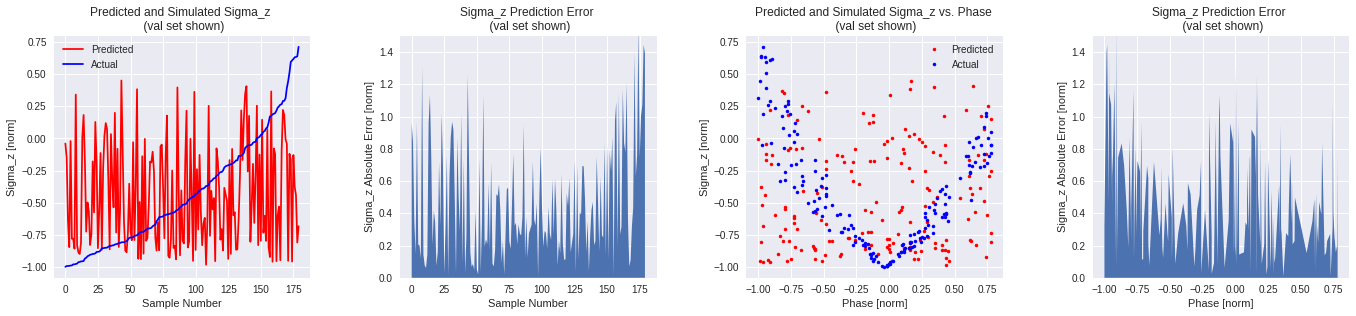

In [84]:
# Define NN and training parameters
nn_model = nn.MLPRegressor(
       activation='tanh', 
       alpha=0.0001, 
       batch_size=200,
       hidden_layer_sizes=(8,6,4),
       learning_rate='adaptive',
       learning_rate_init=0.01,
       max_iter=1000000,
       solver='adam',
       beta_1=0.9, beta_2=0.999,
       shuffle=True,
       early_stopping=True,
       validation_fraction=0.1,
       verbose=False,
       warm_start=False,
       random_state=3)

# fit NN
nn_model.fit(X_train,Y_train)

# predict on val and train set
val_pred = nn_model.predict(X_val)
train_pred = nn_model.predict(X_train)

# compute and print errors
print('model performance:')
print(' ')
print_trn_val_errors(val_pred,train_pred,Y_val,Y_train)
print(' ')


merged=np.concatenate((X_val,Y_val),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
X_val=sort[:,0:X_val.shape[1]]
Y_val=sort[:,X_val.shape[1]:merged.shape[1]]

# plot results

Sigma_z_plots(val_pred[:,0],Y_val[:,0],X_val[:,0])

### II. Gaussian Process Models

Ok, now let's move on to another ML model: the Gaussian Process (GP) model. With a GP model, you get an estimate of the prediction uncertainty. Here's the boilerplate example from sci-kit learn (see [here](http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py) for more):


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import Matern,RBF, ConstantKernel as C

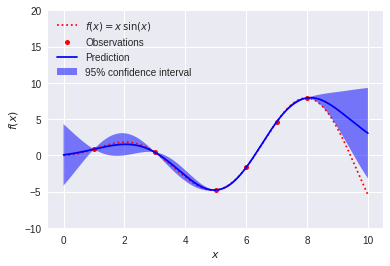

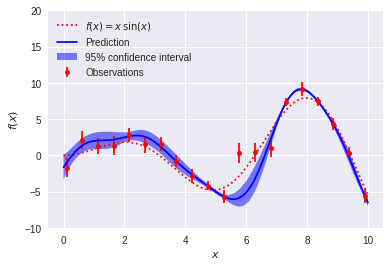

In [86]:
# START BOILERPLATE EXAMPLE FROM SCIKIT LEARN
# ----------------------------------------------------------------------

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instanciate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()
# ----------------------------------------------------------------------
# END BOILERPLATE EXAMPLE FROM SCIKIT LEARN

Ok, let's set it up for our data now...

In [ ]:
# define GP
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
kernel=0.069**2*Matern(length_scale=0.484,nu=1.5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

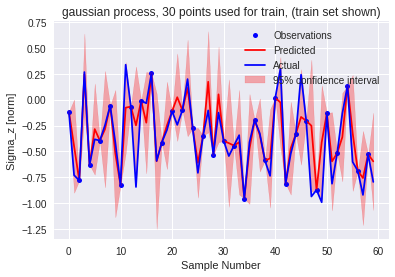

 
GP model performance with 30 training samples:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.07098066       0.07325623           1.03364684              1.00162744               0.18398696               0.20742067
validation error:    0.03651783       0.04271328           1.04547939              1.09511589               0.20383559               0.21899786
 
 


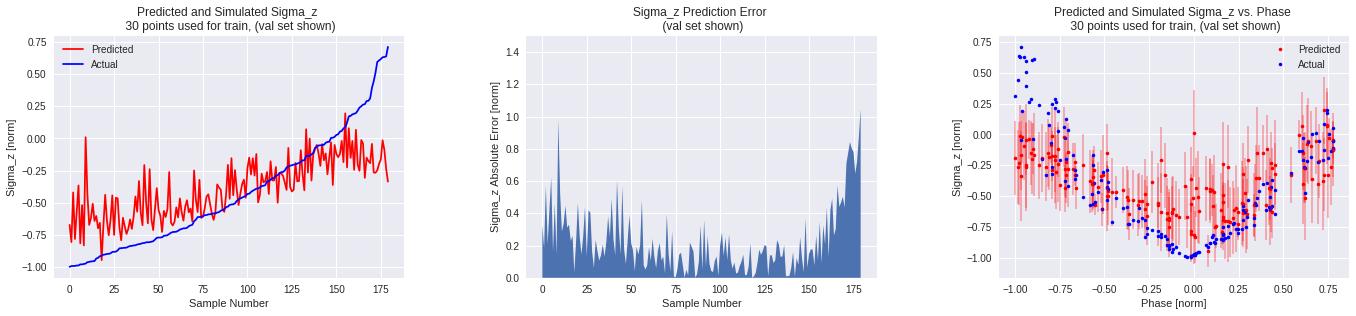

In [88]:
# train model
gp.fit(X_train[0:60:2,:], Y_train[0:60:2,:])

# mesh for generating predictions
x = np.atleast_2d(np.linspace(0, X_test.shape[0], X_test.shape[0])).T

# predict on training set inputs over range used
y_pred, sigma = gp.predict(X_train[0:60], return_std=True)

# make plot showing data, data seen during training, predicted values
# for all input data, and confidence interval
x=np.arange(0,60)

plt.plot(x[::2],Y_train[0:60:2,0], 'b.', markersize=10, label=u'Observations')
plt.plot(x,y_pred[:,0], 'r-', label=u'Predicted')
plt.plot(x,Y_train[0:60,0], 'b-', label=u'Actual')


plt.fill_between(x, y_pred[:,0] - 1.96*sigma,y_pred[:,0] + 1.96*sigma,label='95% confidence interval',color='r',alpha=0.3)

plt.title('gaussian process, 30 points used for train, (train set shown)')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Sigma_z [norm]')
plt.show()

# predict on all validation and training inputs
y_pred, sigma = gp.predict(X_val, return_std=True)
y_pred_train, sigma1 = gp.predict(X_train, return_std=True)

# compute and print errors
print(' ')
print('GP model performance with 30 training samples:')
print(' ')
print_trn_val_errors(y_pred,y_pred_train,Y_val,Y_train)
print(' ')

# plot results
Sigma_z_plots_gp(y_pred,Y_val,X_val,sigma,' 30 points used for train, (val set shown)')

#### b. 30 training samples, sparser data

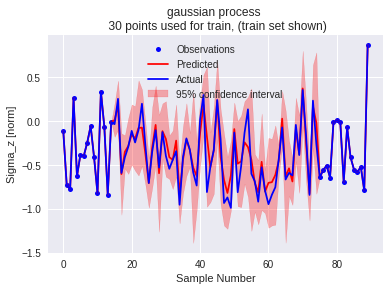

 
GP model performance with 30 training samples (and sparse in center):
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.07098066       0.07325623           1.03364684              1.00162744               0.18398696               0.20742067
validation error:    0.04211380       0.04791561           0.67946502              0.69350916               0.12877696               0.14262586
 
 


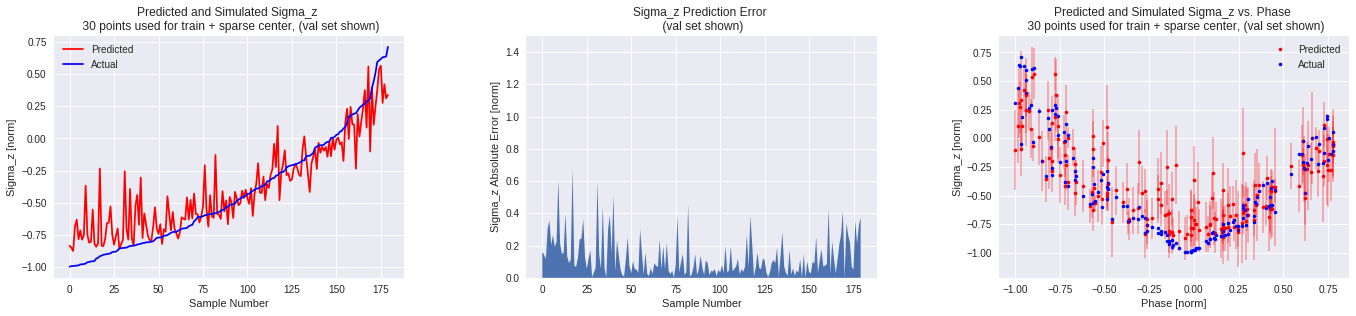

In [89]:
# split data into sets of 15 training points on either end of 90 samples total
X_sparse=np.concatenate((X_train[0:15,:],X_train[75:90,:]),axis=0)
Y_sparse=np.concatenate((Y_train[0:15,:],Y_train[75:90,:]),axis=0)

# train model
gp.fit(X_sparse, Y_sparse)

# predict on training set over range used
y_pred, sigma = gp.predict(X_train[0:90,:], return_std=True)


# make plot showing data, data seen during training, predicted values
# for all input data, and confidence interval
x=np.arange(0,90)

plt.plot(x[0:15],Y_train[0:15,0], 'b.', markersize=10, label=u'Observations')
plt.plot(x[75:90],Y_train[75:90,0], 'b.', markersize=10)
plt.plot(x,y_pred[:,0], 'r-', label=u'Predicted')
plt.plot(x,Y_train[0:90,0], 'b-', label=u'Actual')
plt.fill_between(x, y_pred[:,0] - 1.96*sigma,y_pred[:,0] + 1.96*sigma,label='95% confidence interval',color='r',alpha=0.3)

plt.title('gaussian process \n 30 points used for train, (train set shown)')
plt.legend(loc='best')
plt.xlabel('Sample Number')
plt.ylabel('Sigma_z [norm]')

plt.show()

# predict output over validation set
y_pred, sigma = gp.predict(X_val, return_std=True)

# compute and print errors
print(' ')
print('GP model performance with 30 training samples (and sparse in center):')
print(' ')
print_trn_val_errors(y_pred,y_pred_train,Y_val,Y_train)
print(' ')

merged=np.concatenate((X_val,Y_val),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
X_val=sort[:,0:X_val.shape[1]]
Y_val=sort[:,X_val.shape[1]:merged.shape[1]]

y_pred, sigma = gp.predict(X_val, return_std=True)

# plot results
Sigma_z_plots_gp(y_pred,Y_val,X_val,sigma,' 30 points used for train + sparse center, (val set shown)')



Let's double the data and see how it does:

#### c. 60 training samples

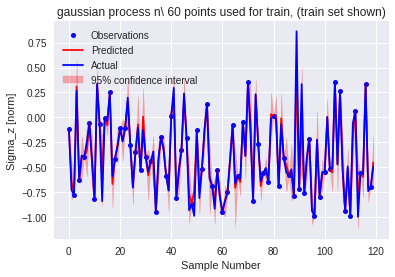

 
GP model performance, trained on 60 samples:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.07098066       0.07325623           1.03364684              1.00162744               0.18398696               0.20742067
validation error:    0.00381252       0.00023273           0.77240248              0.61733837               0.11361815               0.10580151
 
 


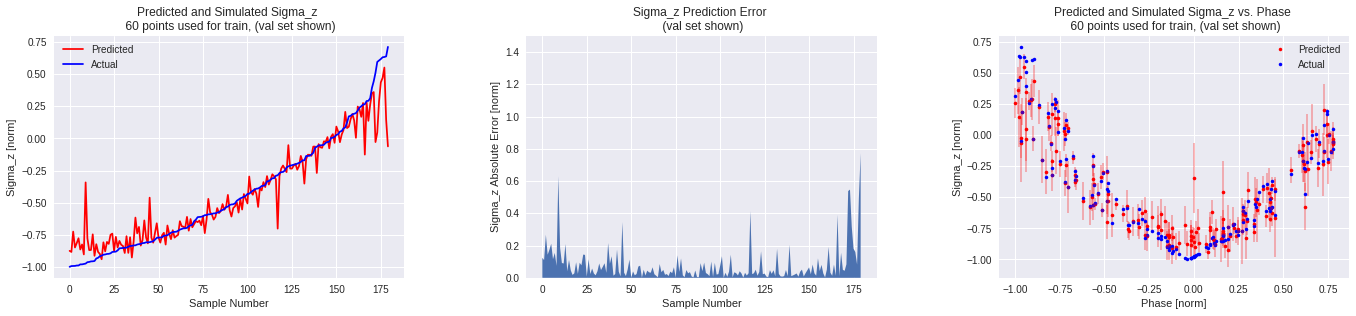

In [90]:
# train model
gp.fit(X_train[0:120:2,:], Y_train[0:120:2,:])

# predict over training data range
y_pred, sigma = gp.predict(X_train[0:120], return_std=True)

# make plot showing data, data seen during training, predicted values
# for all input data, and confidence interval
x=np.arange(0,120)

plt.plot(x[::2],Y_train[0:120:2,0], 'b.', markersize=10, label=u'Observations')
plt.plot(x,y_pred[:,0], 'r-', label=u'Predicted')
plt.plot(x,Y_train[0:120,0], 'b-', label=u'Actual')
plt.fill_between(x, y_pred[:,0] - 1.96*sigma,y_pred[:,0] + 1.96*sigma,label='95% confidence interval',color='r',alpha=0.3)
plt.title('gaussian process n\ 60 points used for train, (train set shown)')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Sigma_z [norm]')

plt.show()

# predict output over validation set
y_pred, sigma = gp.predict(X_val, return_std=True)

# compute and print errors
print(' ')
print('GP model performance, trained on 60 samples:')
print(' ')
print_trn_val_errors(y_pred,y_pred_train,Y_val,Y_train)
print(' ')

merged=np.concatenate((X_val,Y_val),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
X_val=sort[:,0:X_val.shape[1]]
Y_val=sort[:,X_val.shape[1]:merged.shape[1]]

y_pred, sigma = gp.predict(X_val, return_std=True)

# plot results
Sigma_z_plots_gp(y_pred,Y_val,X_val,sigma,' 60 points used for train, (val set shown)')

#### d. 600 training samples

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


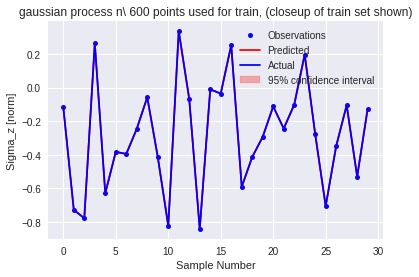

 
GP model performance, trained on 600 samples:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
training error:      0.07098066       0.07325623           1.03364684              1.00162744               0.18398696               0.20742067
validation error:    0.00116820       0.00048055           0.11921263              0.15927814               0.01953883               0.02593708
 


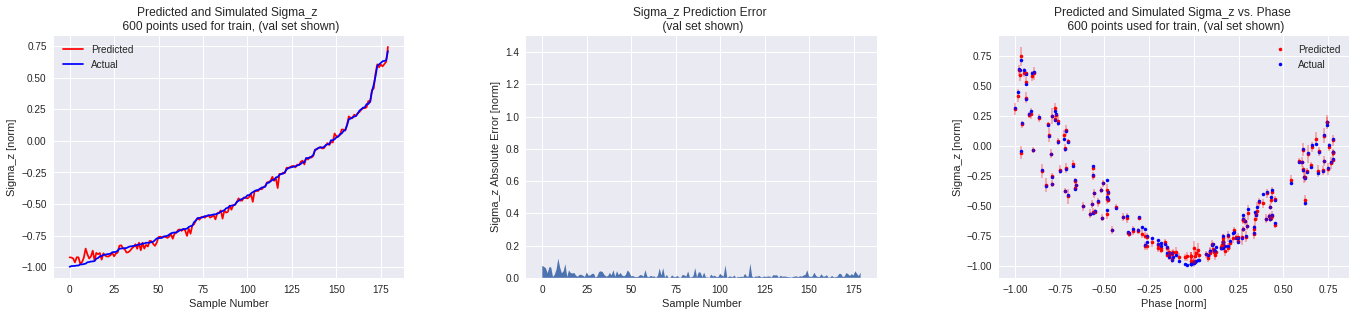

In [91]:
# train model
gp.fit(X_train[0:600,:], Y_train[0:600,: ])

# predict over training range
y_pred, sigma = gp.predict(X_train[0:30], return_std=True)


# make plot showing data, data seen during training, predicted values
# for all input data, and confidence interval
plt.plot(Y_train[0:30,0], 'b.', markersize=10, label=u'Observations')
plt.plot(y_pred[:,0], 'r-', label=u'Predicted')
plt.plot(Y_train[0:30,0], 'b-', label=u'Actual')
plt.fill_between(np.arange(0,30), y_pred[:,0] - 1.96*sigma,y_pred[:,0] + 1.96*sigma,label='95% confidence interval',color='r',alpha=0.3)

plt.title('gaussian process n\ 600 points used for train, (closeup of train set shown)')
plt.xlabel('Sample Number')
plt.ylabel('Sigma_z [norm]')
plt.legend()

plt.show()

# predict over validation set
y_pred, sigma = gp.predict(X_val, return_std=True)

# compute and print errors
print(' ')
print('GP model performance, trained on 600 samples:')
print(' ')
print_trn_val_errors(y_pred,y_pred_train,Y_val,Y_train)

merged=np.concatenate((X_val,Y_val),axis=1)
sort=np.copy(merged)
sort=sort[sort[:,-2].argsort(kind='mergesort')]
X_val=sort[:,0:X_val.shape[1]]
Y_val=sort[:,X_val.shape[1]:merged.shape[1]]

y_pred, sigma = gp.predict(X_val, return_std=True)

# plot results
Sigma_z_plots_gp(y_pred,Y_val,X_val,sigma,' 600 points used for train, (val set shown)')

Let's see how well this translates to our "challenge" set:

##### -extrapolation

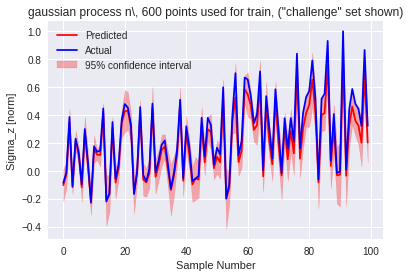

 
model performance on "challenge" set:
 
 
                     sigma_z MAE      sigma_delta MAE      sigma_z peak AE         sigma_delta peak AE      sigma_z STD AE           sigma_delta STD AE
error:               0.05725387       0.07099450           0.21001176              0.17889720               0.04495199               0.04768252
 


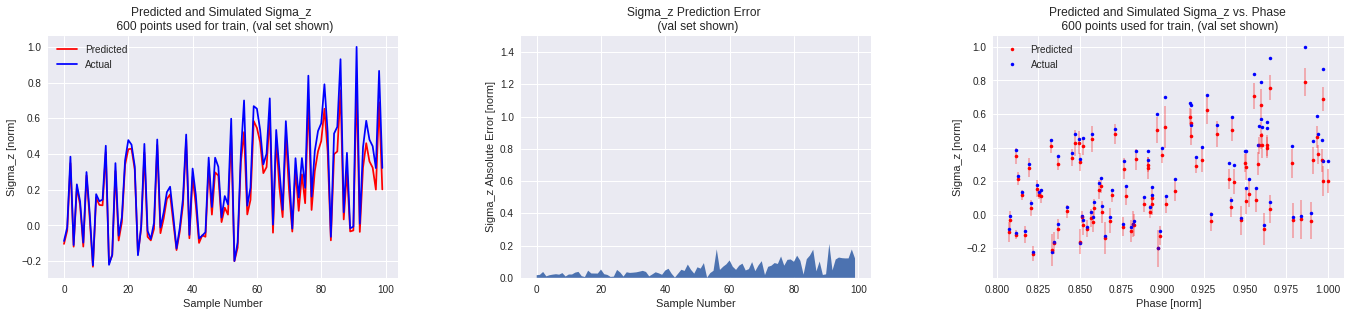

In [92]:
#How about on the challenge set?

# predict on extended set
y_pred, sigma = gp.predict(Xt_stretch, return_std=True)

# plot data
plt.plot(y_pred[:,0], 'r-', label=u'Predicted')
plt.plot(Yt_stretch[:,0], 'b-', markersize=10, label=u'Actual')
plt.title('gaussian process n\, 600 points used for train, ("challenge" set shown)')
plt.fill_between(np.arange(0,Yt_stretch.shape[0]), y_pred[:,0] - 1.96*sigma,y_pred[:,0] + 1.96*sigma,label='95% confidence interval',color='r',alpha=0.3)
plt.xlabel('Sample Number')
plt.ylabel('Sigma_z [norm]')
plt.legend()
plt.show()

# compute and print errors
print(' ')
print('model performance on "challenge" set:')
print(' ')
print_error(y_pred,Yt_stretch)

# plot results
Sigma_z_plots_gp(y_pred,Yt_stretch,Xt_stretch,sigma,' 600 points used for train, (val set shown)')

You can see higher uncertainty for data that fell outside of the original training data range.